# El problema de la rana

El _problema de la rana_ es un ejercicio de probabilidad que dice lo siguiente: supongamos que hay una rana que siempre salta la misma distancia, y cada vez que salta lo hace en una dirección aleatoria, entonces

1. ¿Cuál es la distancia media recorrida, respecto al origen, después de $n$ saltos?
2. ¿Cuál es la distribución de probabilidad (aproximada) de la distancia al origen después de $n$ saltos?

Asumimos que la rana salta en un plano, y que "dirección aleatoria" quiere decir que la variable aleatoria que define la dirección de salto sigue una distribución uniforme, entonces la variable aleatoria que define la distancia tras $n$ saltos viene dada por
$$
Y_n=\left|\sum_{k=1}^n e^{i X_k}\right|=\sqrt{n+2\sum_{1\le j< k\le n}\cos (X_j-X_k)}
$$
donde cada $X_k$ es independiente de la otra y todas tienen una distribución uniforme en $[0,2\pi]$. También tenemos la identidad $Y_n=|Y_{n-1}+e^{i X_n}|$. Dos formas de atacar el problema: a través de una simulación con números pseudoaleatorios, o analíticamente. 

## Aproximación teórica

A partir de $n\ge 3$ se hace complicado calcular explícitamente la función de densidad de $Y_n$, así que en principio nos tendríamos que contentar con una aproximación teórica. Para esto podemos utilizar el teorema central del límite para vectores aleatorios, ya que también podemos representar cada salto aleatorio por el vector $V_k:=(\cos(X_j),\sin(X_j))$, entonces sabemos que si la varianza de cada $V_k$ es finita
$$
\frac1{\sqrt n}\left(\sum_{k=1}^n V_k-\mu\right)\overset{\text{distribución}}{\longrightarrow}N,\quad n\to\infty
$$
donde $N$ es una variable aleatoria con distribución binormal de media $\mu$ y covarianza igual a las de los $V_k$, siendo $\mu$ la media de los $V_k$. A partir de ahí se puede mostrar que la distribución de $Y_n/\sqrt n$ se aproxima a $2x e^{-x^2}$ conforme $n$ tiende a infinito, y por tanto
$$
f_{Y_n}(x)\approx \frac{2x}{n}e^{-\frac{x^2}n}
$$
para $n$ suficientemente grande.

## Simulación con números pseudo-aleatorios

Si fuésemos a hacer una simulación podríamos usar un código como el siguiente para simular la distancia recorrida tras $n$ saltos

In [1]:
function rd(n::Int)
    p = 1.0 # el primer salto
    for j in 2:n
        p += exp(2pi * im * rand())
    end
    return abs(p)
end;

Después necesitamos generar una gran cantidad de datos para hallar valores estadísticos y graficar un histograma que aproxime la función de densidad de cada $Y_n$, para lo que podemos usar algo así

In [2]:
function sim(n::Int, m::Int = 22)
    datos = zeros(2^m) # matriz inicializada
    for i in 1:2^m
        datos[i] = rd(n)
    end
    return datos
end;

donde el parámetro `m` es opcional y controla la cantidad de experimentos a realizar. Finalmente podemos graficar, comparando la simulación con la aproximación teórica anterior, con algo así

In [3]:
using KernelDensity, Plots
function p1(n::Int, m::Int= 22; cdf::Int = -1, c::Symbol = :auto)
    r = 0:n/100:n
    k = kde(sim(n,m))
    cdf <= 0 && begin
        p = plot!(r, pdf.(Ref(k), r),
            color = c,
            xlabel = "Distancia recorrida",
            label = "PDF estimada tras $n saltos")
        f(y) = 2y*exp(-y^2/n)/n
        p = plot!(f, 0, n, l = :dash, w = 3, color = c,
            label = "PDF aproximada con TCL tras $n saltos")
        end
    cdf >= 0 && begin
        x = pdf.(Ref(k),r)
        cdfx = cumsum(x)/sum(x)
        p = plot!(r, cdfx, color = c,
            label = "CDF estimada tras $n saltos")
        g(y) = 1- exp(-y^2/n)
        p = plot!(g, 0, n, l = :dash, w = 3, color = c,
            label = "CDF aproximada con TCL tras $n saltos")
        end
return p
end;

Cada vez que llamamos a la función `p1` añade una gráfica más sobre la anterior (usan el mismo lienzo), los parámetros `m` y `c` son opcionales, el primero, al igual que antes, controla la cantidad de experimentos sobre la que hacer las estimaciones, y el segundo [la paleta de colores a usar](https://docs.juliaplots.org/latest/colors/). Un ejemplo

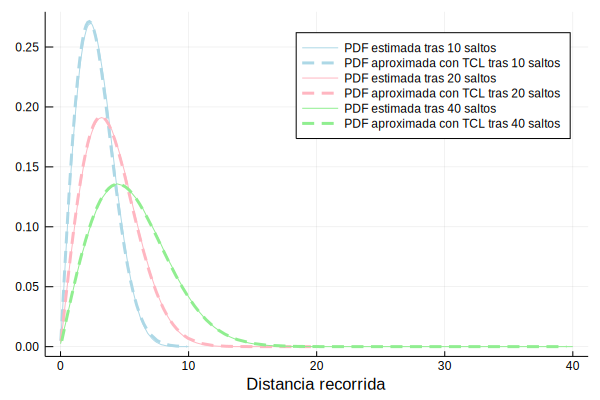

In [4]:
p1(10, c=:blues); p1(20, c=:reds); p1(40, c=:greens)

Y con la misma función podemos dibujar las funciones de distribución acumuladas, añadiendo la opción `cdf = 1`

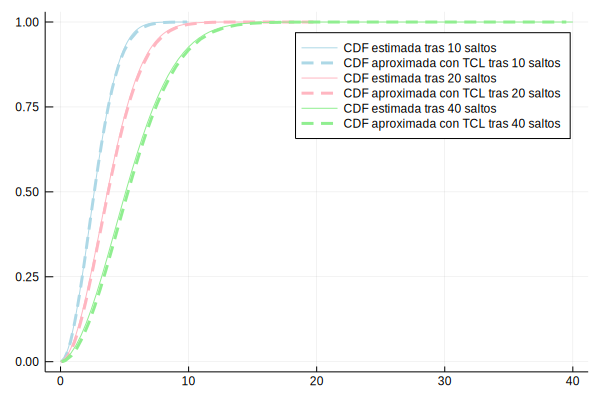

In [6]:
plot(); # Reseatmos el lienzo para empezar a graficar en uno nuevo
p1(10, c=:blues, cdf = 1); p1(20, c=:reds, cdf = 1); p1(40, c=:greens, cdf = 1)